## Data cleaning, wrangling, and create dataframe 

To get detailed information from the dataset, we convert to datetime into day of the year, and convert hours into minute of the day, because we expect tempature is relevant to daily and seasonal flunctuation. 

In [1]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn import linear_model
from datetime import datetime
import pandas as pd


def create_df(years): 

    files = ['/Users/swimmingcircle/cs156_code/session05/CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
    usecols = [1, 2, 8] #column 1: year, 2: hour, 8: temp

    data = [np.loadtxt(f, usecols=usecols) for f in files]
    data = np.vstack(data)

    # Map from HHmm to an integer
    data[:, 1] = np.floor_divide(data[:, 1], 100) * 60 + np.mod(data[:, 1], 100)
    valid = data[:, 2] > -1000

    df = pd.DataFrame(data)

    #filter valid date  
    df = df[df[2] > -1000] 
    df[0] = df[0].astype(int)
    df[3] = pd.to_datetime(df[0], format='%Y%m%d').dt.dayofyear.rename() #convert to datetime & day of the year

    df[4] = df[1].apply(lambda x : np.floor_divide(x, 100) * 60 + np.mod(x, 100)) #minute of the day

    df.columns = ['year', 'hour', 'temp', 'day_of_year', 'min_of_day']
    return df


## Create training and testing dataset 

In [2]:
#train data
years_train = range(2011, 2016)
train_df = create_df(years_train)

#test data
years_test = range(2016, 2017)
test_df = create_df(years_test)


In [3]:
train_df

,year,hour,temp,day_of_year,min_of_day
0,20110101,5.0,-6.4,1,5.0
1,20110101,10.0,-6.5,1,10.0
2,20110101,15.0,-6.5,1,15.0
3,20110101,20.0,-6.5,1,20.0
4,20110101,25.0,-6.7,1,25.0
...,...,...,...,...,...
525883,20151231,1420.0,-1.4,365,860.0
525884,20151231,1425.0,-1.6,365,865.0
525885,20151231,1430.0,-1.4,365,870.0
525886,20151231,1435.0,-1.6,365,875.0


In [4]:
train_df

,year,hour,temp,day_of_year,min_of_day
0,20110101,5.0,-6.4,1,5.0
1,20110101,10.0,-6.5,1,10.0
2,20110101,15.0,-6.5,1,15.0
3,20110101,20.0,-6.5,1,20.0
4,20110101,25.0,-6.7,1,25.0
...,...,...,...,...,...
525883,20151231,1420.0,-1.4,365,860.0
525884,20151231,1425.0,-1.6,365,865.0
525885,20151231,1430.0,-1.4,365,870.0
525886,20151231,1435.0,-1.6,365,875.0


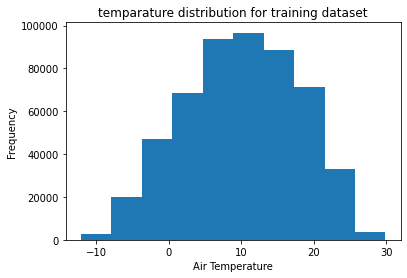

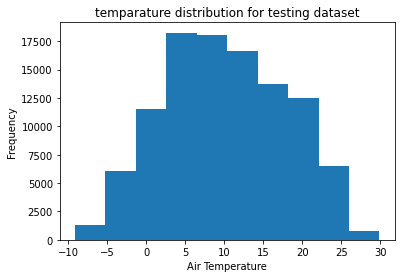

In [5]:
#check temparature 
plt.hist(train_df["temp"])
plt.title('temparature distribution for training dataset')
plt.xlabel("Air Temperature")
plt.ylabel("Frequency")
plt.show()

plt.hist(test_df["temp"])
plt.title('temparature distribution for testing dataset')
plt.xlabel("Air Temperature")
plt.ylabel("Frequency")
plt.show()

We can observe that for both training and testing dataset, the temparature follows a normal distribution, ranging from -10 to 30 degree.

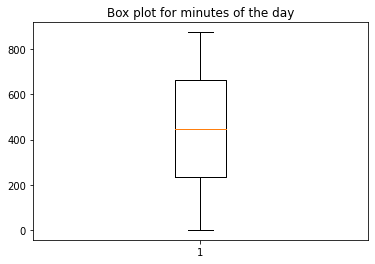

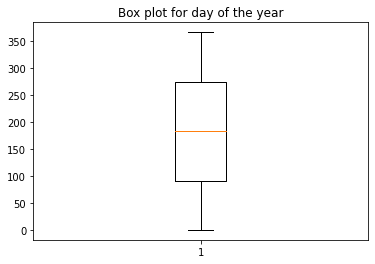

In [6]:
#Investigate min_of_day and day_of_year
plt.boxplot(train_df[['min_of_day']])
plt.title('Box plot for minutes of the day')
plt.show()
plt.boxplot(train_df[['day_of_year']])
plt.title('Box plot for day of the year')
plt.show()

Through the range of the boxplot, we can see that our data wrangling process is correct, and the data aren't skewed for both variables

## Use linear model to train the data

In [7]:
# fit a linear model on training and testing dataset without using kernel 

regr_1 = linear_model.LinearRegression()
regr_1.fit(train_df[['day_of_year','min_of_day']], train_df[['temp']])

y__pred_train = regr_1.predict(train_df[['day_of_year','min_of_day']])
y_pred_test = regr_1.predict(test_df[['day_of_year','min_of_day']])
print("The R-squared for linear regression training date:", r2_score(train_df[['temp']], y__pred_train))
print("The R-squared for linear regression testing date:", r2_score(test_df[['temp']], y_pred_test))


The R-squared for linear regression training date: 0.04957141756322214
The R-squared for linear regression testing date: 0.058666161484717816


We can see that R-square for training data is only around 5%, meaning that only 4% of the variance can be explained by the model. Similarly, R-square for training data is only 6%. It shows that the model doesn't really able to predict the temparature. 

## Train the model by using two variables, days of the year and minutes of the day in the rbf kernel 

We apply two modification here. 
- Apply rbf: We test out kernel to separate the data. Here, we adopt rbf_kernel to project data to higher dimensions. Ridge regression will calculate the distance between the centers with ever x input we have, and create distributions on every center, allowing squiggly regression line. 
- Replace linear ridge regression with ridge regression: Ridge regression add e(the bias parameters) to tackle multicollinearity. We use the Rdige regression to regularize ("shrink") coefficients, so it will avoid over-fitting. 


In [8]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge


def apply_kernel(df, c1, c2):

    '''Apply kernel function to the data, with different numbers of centers, c1, c2'''
    #use kernel function to transform both variable 
    x_day = df[['day_of_year']]
    x_min = df[['min_of_day']]

    y_train = np.asarray(df[['temp']]).reshape(-1, 1)
    sigma = 1000
    alpha = 0.01

    #create centers for the kernel
    center_day = [i for i in range(10, 370, c1)]
    center_min = [i for i in range(10, 1440, c2)]
    center_day = np.asarray(center_day).reshape(-1, 1)
    center_min = np.asarray(center_min).reshape(-1, 1)

    #Use rbf function to create new x 
    kernel_day = rbf_kernel(x_day, center_day, gamma=1.0 / sigma)
    kernel_min = rbf_kernel(x_min, center_min, gamma=1.0 / sigma)

    #x after applying the kernel 
    kernel_x = np.hstack((kernel_day,kernel_min))
    return kernel_x

c1 = c2 = 10 
train_kernel = apply_kernel(train_df, c1, c2)


In [9]:
alpha = 0.01
regr_2 = Ridge(alpha=alpha, fit_intercept=False)
regr_2.fit(train_kernel, train_df[['temp']])
print("After applying the rbf kernel, the R-squared for linear regression training date:", regr_2.score(train_kernel, train_df[['temp']]))

After applying the rbf kernel, the R-squared for linear regression training date: 0.6234749968780156


In [10]:
test_kernel = apply_kernel(test_df,c1, c2)
regr_2.fit(test_kernel, test_df[['temp']])
print("After applying the rbf kernel, the R-squared for linear regression testing date:", regr_2.score(test_kernel, test_df[['temp']]))


After applying the rbf kernel, the R-squared for linear regression testing date: 0.7002619973697294


After applying rbf kernel to both variables, we can see that R-squared drastically rises, the model now can explain around 62% of the data, and around 70% of the testing data. 

## Test different rbf function 

In [18]:
## Testing different rbf function


max_r = 0
best_c1 = 0 
best_c2 = 0 
for c1 in range(10, 50, 10):
    for c2 in range(10, 50, 10):
        train_kernel = apply_kernel(train_df, c1,c2)

        regr_2 = Ridge(alpha=alpha, fit_intercept=False)
        regr_2.fit(train_kernel, train_df[['temp']])

        test_kernel = apply_kernel(test_df, c1,c2)
        regr_2.fit(test_kernel, test_df[['temp']])
        score = regr_2.score(test_kernel, test_df[['temp']])
        if max_r < score:
            max_r = score
            best_c1 = c1
            best_c2 = c2
print('Best r square is', max_r, ' with numbers of centers for days and minutes of the year as ', (c1,c2) )


We observe that adjusting the amount of centers doesn't drastically imporve our prediction. In addition, it takes a long time testing different numbers of centers, showcasing it's expensive to train the kernel. 

### Investigate contribution of days of the year

In [12]:
def one_feature_prediction(df_train, df_test, feature, centers):

    '''Investigate the R square for only using one feature, and return the model'''

    #use kernel function to transform one variable 
    x = df_train[[feature]]

    y_train = np.asarray(df_train[['temp']]).reshape(-1, 1)
    sigma = 1000
    alpha = 0.01

    #create centers for the kernel
    centers = np.asarray(centers).reshape(-1, 1)

    #Use rbf function to create new x 
    train_kernel = rbf_kernel(x, centers, gamma=1.0 / sigma)
    
    #modelling 
    regr= Ridge(alpha=alpha, fit_intercept=False)
    regr.fit(train_kernel, train_df[['temp']])
    
    test_x = df_test[[feature]]
    test_kernel = rbf_kernel(test_x, centers, gamma=1.0 / sigma)
    regr.fit(test_kernel, test_df[['temp']])
    
    print('R square for training set', regr.score(train_kernel, train_df[['temp']])) 
    print('R square for testing set', regr.score(test_kernel, test_df[['temp']])) 

    return regr

day_of_year = 'day_of_year'
center_day = [i for i in range(10, 370, 10)]
print('For day of year:') 
reg_day = one_feature_prediction(train_df, test_df, day_of_year, center_day)



For day of year:
R square for training set 0.47408704301067295
R square for testing set 0.6558998462754665


In [13]:
#prediction for testing dataset  
sigma = 1000
x_day = np.linspace(-3.0, 370.0, 1000).reshape(-1, 1)
center_day = [i for i in range(10, 370, 10)]
center_day = np.asarray(center_day).reshape(-1, 1)

day_test_kernel = rbf_kernel(x_day, center_day, gamma=1.0 / sigma)
pred_y = reg_day.predict(day_test_kernel)



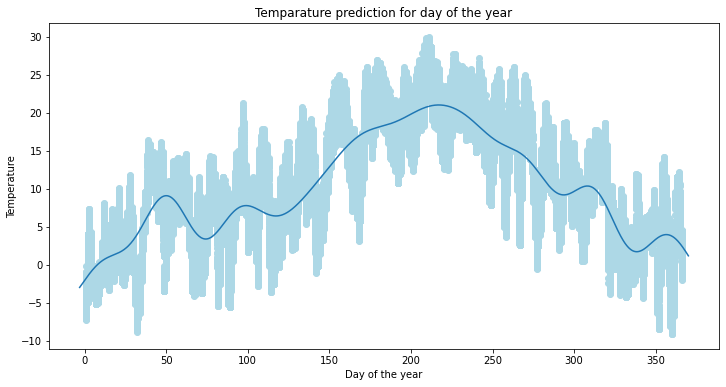

In [14]:
#plot the testing data set for day_of_year
plt.figure(figsize=(12, 6))
plt.plot(x_day, pred_y)
plt.scatter(test_df['day_of_year'], test_df['temp'], color = 'lightblue')
plt.xlabel("Day of the year")
plt.ylabel("Temperature")
plt.title('Temparature prediction for day of the year')
plt.show()

We can see that days of the years contribute around 47% of explaination to the temparatur for training dataset, and contribute around 66% of explaination to the temparatur for testing dataset. It showcases that days of the years is crucial to predict the temparature. 

This is confirmed by the plot above. It shows that the tempature flunctuate in different days, and the model is able to capture the overall trend.

### Investigate contribution of minutes of the day

In [15]:
min_of_day = 'min_of_day'
center_min = [i for i in range(10, 1440, 10)]
print('For min of day:') 
reg_min = one_feature_prediction(train_df, test_df, min_of_day, center_min)

For min of day:
R square for training set 0.0439634165680004
R square for testing set 0.044074725653252655


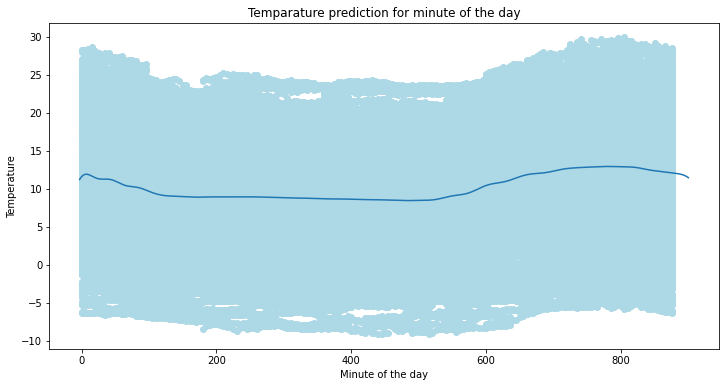

In [16]:
#prediction for testing dataset  

x_min = np.linspace(-3.0, 900.0, 1000).reshape(-1, 1)
center_min = np.asarray(center_min).reshape(-1, 1)
min_test_kernel = rbf_kernel(x_min, center_min, gamma=1.0 / sigma)
pred_y = reg_min.predict(min_test_kernel)

#plot the testing data set for min_of_day
plt.figure(figsize=(12, 6))
plt.plot(x_min, pred_y)
plt.scatter(test_df['min_of_day'], test_df['temp'], color = 'lightblue')
plt.xlabel("Minute of the day")
plt.ylabel("Temperature")
plt.title('Temparature prediction for minute of the day')
plt.show()


We can see that minutes of the days contribute around 4% of explaination to the temparatur for both training dataset and testing dataset. It showcases that days of the years isn't important to predict the temparature. 

This is also confirmed by the plot above. It shows that the tempature doesn't have much daily flunctuation, so the model doens't able to provide much information to predict the daily temparature. 

## Make a 3D plot showing temperature as a function of (day, time). 

In [17]:
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(12, 6))
# ax = fig.add_subplot(projection='3d')

# all_x = np.concatenate([x_day, x_min],  axis = 1)

# # test_prediction = regr_2.predict(all_x)
# # Plot a basic wireframe.
# ax.plot_wireframe(x_day, x_min, test_prediction, rstride=10, cstride=10)

# plt.show()
